All the existing models in Brain-Score have their layers committed to certain cortical regions, e.g. such that the output of block 42 in a transformer corresponds to neural activity in the human language system.

In some cases, testing individual layers of a base model is desirable, e.g. in exploratory analyses of hierarchical correspondences, or to commit layers of a new model to cortical regions.
Note however, that ultimately all models submitted to Brain-Score must declare neural commitments, so that always the same model units are used to compare against a particular cortical brain region.


This example uses the HuggingfaceSubject wrapper which allows us to easily access base models, and allows to specify a mapping of regions to layers in the constructor.

Let's first create a model without a layer commitment:

In [1]:
from brainscore_language.model_helpers.huggingface import HuggingfaceSubject
from brainscore_language import ArtificialSubject

model = HuggingfaceSubject(model_id='distilgpt2', region_layer_mapping={})

The `distilgpt2` model consists of 6 transformer blocks:

In [2]:
print(model.basemodel)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

By creating new artificial subject models, we can test each block separately (note that here we choose to test the first LayerNorm `ln_1` for each block, but you can specify other modules):

In [ ]:
from tqdm import tqdm
from brainscore_core.supported_data_standards.brainio.assemblies import merge_data_arrays
from brainscore_language import load_benchmark

benchmark = load_benchmark('Pereira2018.243sentences-linear')

layer_scores = []
for layer in tqdm([f'transformer.h.{block}.ln_1' for block in range(6)], desc='layers'):
    layer_model = HuggingfaceSubject(model_id='distilgpt2', region_layer_mapping={
        ArtificialSubject.RecordingTarget.language_system: layer})
    layer_score = benchmark(layer_model)
    # package for xarray
    layer_score = layer_score.expand_dims('layer')
    layer_score['layer'] = [layer]
    layer_scores.append(layer_score)
layer_scores = merge_data_arrays(layer_scores)
print(layer_scores)

layers: 100%|██████████████████████████████████████████████████████| 6/6 [22:58<00:00, 229.82s/it]

<xarray.Score (layer: 6)>
array([0.11768127, 0.36386201, 0.49107396, 0.48109876, 0.63456412,
       0.66867011])
Coordinates:
  * layer    (layer) <U20 'transformer.h.0.ln_1' ... 'transformer.h.5.ln_1'
Attributes:
    raw:      <xarray.Score (layer: 1)>\narray([0.04163437])\nCoordinates:\n ...
    ceiling:  <xarray.Score 'data' ()>\narray(0.35378928)\nAttributes:\n    e...


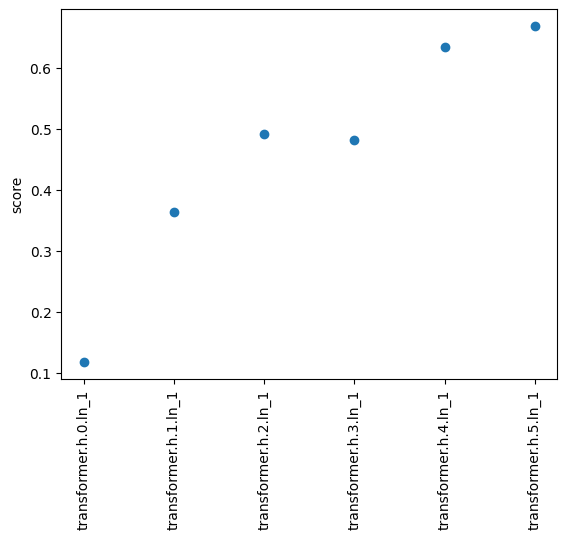

In [5]:
import numpy as np
from matplotlib import pyplot

fig, ax = pyplot.subplots()
x = np.arange(len(layer_scores))
ax.scatter(x, layer_scores)
ax.set_xticks(x)
ax.set_xticklabels(layer_scores['layer'].values, rotation=90)
ax.set_ylabel('score')
fig.show()